In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from einops import rearrange
from moe import sdd_kernel
from model import MoeMLP, MoeMLPForLoop
from tqdm import tqdm
@dataclass
class ToyMoEConfig:
    n_embd: int = 256
    num_experts: int = 4
    num_experts_per_tok: int = 2
    norm_topk_prob: bool = True
    bias: bool = True
    dropout: float = 0.0
config = ToyMoEConfig()

# Create toy input
batch_size = 64
seq_len = 8192
x = torch.randn(batch_size, seq_len, config.n_embd,device='cuda')
# print(f"\nInput shape: {x.shape}")

# Create MoeMLP instance
moe_mlp = MoeMLP(config).cuda()

# Test forward pass
print(f"\n=== Forward Pass ===")
block_sparse, router_logits, debug_info = moe_mlp(x)
print(f"\nForward pass completed!")
print(f"Router logits shape: {router_logits.shape}")
print(f"Triton output shape: {block_sparse.shape}")

# Extract debug variables
col_indices_ptr = debug_info['col_indices_ptr']
row_indices_ptr = debug_info['row_indices_ptr']
selected_experts = debug_info['selected_experts']
selected_experts_sorted = debug_info['selected_experts_sorted']



=== Forward Pass ===

Forward pass completed!
Router logits shape: torch.Size([524288, 4])
Triton output shape: torch.Size([1048576, 2048])


In [2]:
# Debug: Check which experts are being used
print("=== EXPERT USAGE ANALYSIS ===")
print("col_indices_ptr:", col_indices_ptr)

# Use the debug info from the forward pass
selected_experts_flat = selected_experts.reshape(-1)

print("selected_experts_sorted (first 20):", selected_experts_sorted[:20])
print("selected_experts_flat (first 20):", selected_experts_flat[:20])

print("\nExpert distribution:")
for i in range(config.num_experts):
    count = (selected_experts_flat == i).sum()
    print(f"  Expert {i}: {count} blocks ({count/len(selected_experts_flat)*100:.1f}%)")

print("\nRouter logits sample (first 5 tokens):")
print(router_logits[:5])

print("\nSelected experts (first 10 tokens):")
print(selected_experts[:10])

# Get router weights for display
router_weights = F.softmax(router_logits, dim=1, dtype=torch.float)
router_weights_topk, _ = torch.topk(router_weights, config.num_experts_per_tok, dim=-1)
if config.norm_topk_prob:
    router_weights_topk /= router_weights_topk.sum(dim=-1, keepdim=True)

print("\nRouter weights (first 5 tokens):")
print(router_weights_topk[:5])


=== EXPERT USAGE ANALYSIS ===
col_indices_ptr: tensor([ 0,  1,  2,  ..., 13, 14, 15], device='cuda:0', dtype=torch.int16)
selected_experts_sorted (first 20): tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0', dtype=torch.int16)
selected_experts_flat (first 20): tensor([1, 0, 1, 3, 3, 1, 2, 3, 1, 0, 0, 3, 0, 2, 0, 1, 3, 0, 3, 1],
       device='cuda:0', dtype=torch.int16)

Expert distribution:
  Expert 0: 262408 blocks (25.0%)
  Expert 1: 261386 blocks (24.9%)
  Expert 2: 262402 blocks (25.0%)
  Expert 3: 262380 blocks (25.0%)

Router logits sample (first 5 tokens):
tensor([[ 0.1041,  1.4439, -1.3162, -0.0446],
        [-0.7775,  0.4321, -0.5259,  0.1397],
        [-0.2812,  0.1835,  0.0667,  0.3097],
        [-0.7469, -0.3918,  1.1890,  0.1480],
        [ 0.2818,  0.5865, -0.8677,  0.1928]], device='cuda:0',
       grad_fn=<SliceBackward0>)

Selected experts (first 10 tokens):
tensor([[1, 0],
        [1, 3],
        [3, 1],
        [2, 3],
    

In [3]:
# Debug: Analyze block_sparse pattern
print("=== BLOCK_SPARSE PATTERN ANALYSIS ===")
print(f"block_sparse shape: {block_sparse.shape}")

# Check if certain columns are always zero
nonzero_cols = torch.any(block_sparse != 0, dim=0)
print(f"Non-zero columns: {torch.sum(nonzero_cols)} out of {block_sparse.shape[1]}")

if torch.sum(nonzero_cols) > 0:
    first_nonzero = torch.argmax(nonzero_cols.float())
    last_nonzero = len(nonzero_cols) - 1 - torch.argmax(torch.flip(nonzero_cols.float(), [0]))
    print(f"First non-zero col: {first_nonzero}")
    print(f"Last non-zero col: {last_nonzero}")
    print(f"Non-zero range: columns {first_nonzero} to {last_nonzero}")

# Check weight matrix structure
print(f"\nWeight matrix w1 shape: {moe_mlp.w1.shape}")
print(f"d_ffn per expert: {moe_mlp.d_ffn}")
print(f"Total experts: {config.num_experts}")
print(f"Expected w1 width: {moe_mlp.d_ffn * config.num_experts}")

# Show which parts of w1 should correspond to each expert
print(f"\nExpert weight matrix ranges:")
for i in range(config.num_experts):
    start_col = i * moe_mlp.d_ffn
    end_col = (i + 1) * moe_mlp.d_ffn
    print(f"  Expert {i}: columns {start_col} to {end_col-1}")

# Check basic stats
print(f"\nblock_sparse stats:")
print(f"  Non-zero elements: {torch.count_nonzero(block_sparse)}")
print(f"  Min value: {block_sparse.min():.6f}")
print(f"  Max value: {block_sparse.max():.6f}")
print(f"  Mean: {block_sparse.mean():.6f}")
print(f"  Std: {block_sparse.std():.6f}")


=== BLOCK_SPARSE PATTERN ANALYSIS ===
block_sparse shape: torch.Size([1048576, 2048])
Non-zero columns: 2048 out of 2048
First non-zero col: 0
Last non-zero col: 2047
Non-zero range: columns 0 to 2047

Weight matrix w1 shape: torch.Size([256, 2048])
d_ffn per expert: 512
Total experts: 4
Expected w1 width: 2048

Expert weight matrix ranges:
  Expert 0: columns 0 to 511
  Expert 1: columns 512 to 1023
  Expert 2: columns 1024 to 1535
  Expert 3: columns 1536 to 2047

block_sparse stats:


OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 GiB. GPU 0 has a total capacity of 23.57 GiB of which 5.54 GiB is free. Including non-PyTorch memory, this process has 17.90 GiB memory in use. Of the allocated memory 11.59 GiB is allocated by PyTorch, and 6.01 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [4]:
# Debug: Check kernel indexing calculation
print("=== KERNEL INDEXING DEBUG ===")

# Show the relationship between col_indices_ptr and the actual expert columns in w1
print(f"BLOCK_N: {moe_mlp.BLOCK_N}")
print(f"col_indices_ptr: {col_indices_ptr}")

for i, expert_id in enumerate(col_indices_ptr):
    expected_col_start = expert_id * moe_mlp.BLOCK_N  # This is what the kernel calculates
    actual_expert_start = expert_id * moe_mlp.d_ffn   # This is where expert weights actually are
    print(f"Block {i}: expert_id={expert_id}")
    print(f"  Kernel will use columns {expected_col_start} to {expected_col_start + moe_mlp.BLOCK_N - 1}")
    print(f"  Expert {expert_id} weights are at columns {actual_expert_start} to {actual_expert_start + moe_mlp.d_ffn - 1}")
    print(f"  Match: {expected_col_start == actual_expert_start and moe_mlp.BLOCK_N == moe_mlp.d_ffn}")

# Test with a simple manual calculation to verify the kernel is working
print(f"\n=== MANUAL VERIFICATION ===")
print(f"If all tokens use expert 0, we should see non-zeros in columns 0 to {moe_mlp.d_ffn-1}")
print(f"If all tokens use expert 1, we should see non-zeros in columns {moe_mlp.d_ffn} to {2*moe_mlp.d_ffn-1}")

# Check the actual pattern
active_regions = []
for i in range(config.num_experts):
    start_col = i * moe_mlp.d_ffn
    end_col = (i + 1) * moe_mlp.d_ffn
    region_has_values = torch.any(block_sparse[:, start_col:end_col] != 0)
    active_regions.append(region_has_values.item())
    print(f"Expert {i} region (cols {start_col}-{end_col-1}): {'ACTIVE' if region_has_values else 'INACTIVE'}")

print(f"\nActive expert regions: {[i for i, active in enumerate(active_regions) if active]}")


=== KERNEL INDEXING DEBUG ===
BLOCK_N: 128
col_indices_ptr: tensor([ 0,  1,  2,  3,  0,  1,  2,  3,  0,  1,  2,  3,  0,  1,  2,  3,  4,  5,
         6,  7,  4,  5,  6,  7,  4,  5,  6,  7,  4,  5,  6,  7,  8,  9, 10, 11,
         8,  9, 10, 11,  8,  9, 10, 11,  8,  9, 10, 11,  8,  9, 10, 11, 12, 13,
        14, 15, 12, 13, 14, 15, 12, 13, 14, 15], device='cuda:0',
       dtype=torch.int16)
Block 0: expert_id=0
  Kernel will use columns 0 to 127
  Expert 0 weights are at columns 0 to 511
  Match: False
Block 1: expert_id=1
  Kernel will use columns 128 to 255
  Expert 1 weights are at columns 512 to 1023
  Match: False
Block 2: expert_id=2
  Kernel will use columns 256 to 383
  Expert 2 weights are at columns 1024 to 1535
  Match: False
Block 3: expert_id=3
  Kernel will use columns 384 to 511
  Expert 3 weights are at columns 1536 to 2047
  Match: False
Block 4: expert_id=0
  Kernel will use columns 0 to 127
  Expert 0 weights are at columns 0 to 511
  Match: False
Block 5: expert_id=1


In [5]:
# Print the FULL block_sparse tensor (as requested)
print("=== FULL BLOCK_SPARSE TENSOR ===")
torch.set_printoptions(threshold=float('inf'), linewidth=200)
print("block_sparse (full tensor):")
print(block_sparse[-1][-513:])

# Reset print options to default
torch.set_printoptions(profile="default")


=== FULL BLOCK_SPARSE TENSOR ===
block_sparse (full tensor):
tensor([ 0.0000e+00,  2.6926e-01, -8.1338e-02,  2.6226e-01,  5.4215e-01,  2.7640e-02,  2.3499e-01,  1.2705e-01, -1.3455e-01, -3.7021e-03, -2.4632e-02,  9.0736e-02, -1.3818e-01,  6.5356e-02,
        -1.5040e-01,  1.2116e-01, -1.3425e-01, -3.0967e-02, -1.5807e-01,  1.8653e-01,  1.6502e-02, -2.3237e-02,  3.1569e-01,  1.4938e-01, -8.0353e-02, -7.7136e-02,  1.0407e-01,  5.7695e-02,
         2.1366e-01,  9.5126e-02,  2.1498e-02, -1.5793e-01,  1.6925e-02, -1.6485e-01, -1.6990e-01, -8.8731e-02,  6.1982e-01, -2.3962e-02, -6.8072e-02, -6.1540e-02, -1.4892e-02,  1.2581e-01,
         4.2467e-01,  6.2378e-02, -8.8069e-02, -1.0995e-01,  1.1201e-01, -1.8690e-02,  7.0562e-02, -7.2543e-02, -1.6666e-01,  1.3426e-01,  1.2540e-01, -1.4447e-03, -2.4653e-02,  2.1892e-01,
        -4.0085e-02, -6.3039e-02, -1.2491e-01,  2.1506e-02, -1.2043e-01, -1.0383e-01,  3.7549e-01,  7.3281e-01,  2.7233e-01,  5.6924e-02, -6.3662e-02,  1.7367e-01,  6.6285e-01,  1

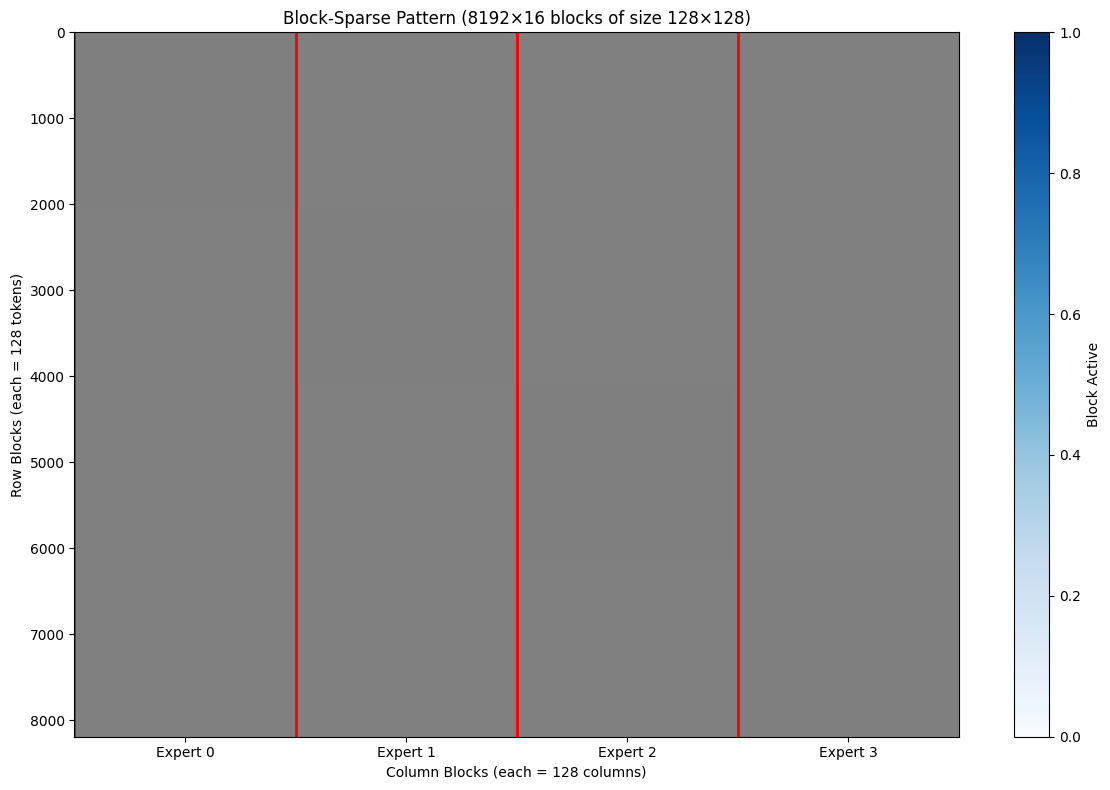

Total blocks: 131072
Active blocks: 32768.0
Sparsity: 75.00%


In [4]:
import matplotlib.pyplot as plt
import torch

def visualize_block_sparse(block_sparse, block_size=128):
    """Visualize a block-sparse matrix by showing which blocks are non-zero"""
    
    # Get dimensions
    M, N = block_sparse.shape
    blocks_m = (M + block_size - 1) // block_size
    blocks_n = (N + block_size - 1) // block_size
    
    # Create a grid showing which blocks have any non-zero values
    block_grid = torch.zeros(blocks_m, blocks_n)
    
    for i in range(blocks_m):
        for j in range(blocks_n):
            # Extract the block
            row_start = i * block_size
            row_end = min((i + 1) * block_size, M)
            col_start = j * block_size
            col_end = min((j + 1) * block_size, N)
            
            block = block_sparse[row_start:row_end, col_start:col_end]
            
            # Check if block has any non-zero values
            if torch.any(torch.abs(block) > 1e-6):
                block_grid[i, j] = 1
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Show the block pattern
    im = ax.imshow(block_grid.cpu().numpy(), cmap='Blues', aspect='auto')
    
    # Add grid lines
    for i in range(blocks_m + 1):
        ax.axhline(i - 0.5, color='gray', linewidth=0.5)
    for j in range(blocks_n + 1):
        ax.axvline(j - 0.5, color='gray', linewidth=0.5)
    
    # Add expert boundaries (assuming 4 blocks per expert)
    blocks_per_expert = 4  # 512 columns / 128 = 4
    for e in range(0, blocks_n, blocks_per_expert):
        ax.axvline(e - 0.5, color='red', linewidth=2)
    
    # Labels
    ax.set_xlabel(f'Column Blocks (each = {block_size} columns)')
    ax.set_ylabel(f'Row Blocks (each = {block_size} tokens)')
    ax.set_title(f'Block-Sparse Pattern ({blocks_m}×{blocks_n} blocks of size {block_size}×{block_size})')
    
    # Add expert labels on x-axis
    expert_positions = [i * blocks_per_expert + blocks_per_expert/2 - 0.5 for i in range(4)]
    ax.set_xticks(expert_positions)
    ax.set_xticklabels([f'Expert {i}' for i in range(4)])
    
    plt.colorbar(im, ax=ax, label='Block Active')
    plt.tight_layout()
    plt.show()
    
    return block_grid

# Use it on your matrix
block_pattern = visualize_block_sparse(block_sparse)

# Print some statistics
print(f"Total blocks: {block_pattern.numel()}")
print(f"Active blocks: {torch.sum(block_pattern).item()}")
print(f"Sparsity: {1 - torch.sum(block_pattern).item() / block_pattern.numel():.2%}")